# 03 — Exploratory Data Analysis

Analyzes the training data: class distribution, feature distributions, correlations, and time series plots.

In [1]:
import sys
import os
import json
from pathlib import Path

PROJECT_FOLDER = "spy_run"
PROJECT_ROOT = Path(os.getcwd()).parent
sys.path.insert(0, str(PROJECT_ROOT))
os.chdir(PROJECT_ROOT)

DATA_CONFIG = PROJECT_ROOT / "config" / PROJECT_FOLDER / "data_config.json"
MODEL_CONFIG = PROJECT_ROOT / "config" / PROJECT_FOLDER / "model_config.json"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed" / PROJECT_FOLDER
RESULTS_DIR = PROJECT_ROOT / "results" / PROJECT_FOLDER
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project folder: {PROJECT_FOLDER}")

Project folder: spy_run


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.facecolor"]  = "white"
plt.rcParams["axes.facecolor"]    = "white"
plt.rcParams["savefig.facecolor"] = "white"
plt.rcParams["figure.figsize"]    = (14, 5)

# Normalized train data (for correlation/MI analysis)
train_df = pd.read_parquet(PROCESSED_DIR / "train.parquet")
with open(PROCESSED_DIR / "metadata.json") as f:
    metadata = json.load(f)

feature_cols = metadata["feature_cols"]
print(f"Train shape: {train_df.shape}")
print(f"Features   : {len(feature_cols)}")

# Unnormalized data (for time series visualization — avoids plotting Z-scores)
import sys
sys.path.insert(0, str(PROJECT_ROOT))
from src.data.collector import DataCollector
from src.features.engineer import FeatureEngineer
from src.features.target import TargetCreator
from src.utils.config_loader import ConfigLoader

config = ConfigLoader(str(DATA_CONFIG), str(MODEL_CONFIG))
raw_df = pd.read_parquet(PROJECT_ROOT / "data" / "raw" / f"{PROJECT_FOLDER}_raw.parquet")
engineer = FeatureEngineer(config)
feat_raw = engineer.create_features(raw_df)
target_creator = TargetCreator.from_config(config)
feat_raw = target_creator.create_target(feat_raw)

# Keep only the training date range
train_end = train_df.index[-1]
feat_raw_train = feat_raw[feat_raw.index <= train_end].copy()
print(f"Unnormalized train shape: {feat_raw_train.shape}")
train_df.head()

Train shape: (4583, 24)
Features   : 22
Unnormalized train shape: (4583, 24)


,Volume,VIX_Close,Close,BB_High,BB_Low,BB_Width,BB_Position,EMA_8,EMA_21,ADX,...,Stoch_K,Stoch_D,ROC_3,ROC_5,Price_Return_1,Price_Return_5,IBS,ATR_pct,forward_return,target
Date,,,,,,,,,,,,,,,,,,,,,
2005-11-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.707921,0
2005-11-28,0.707107,0.707107,-0.707107,0.707107,0.707107,-0.707107,-0.707107,0.707107,0.707107,0.707107,...,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,0.707107,-0.110939,0
2005-11-29,0.513185,0.620712,-0.696951,0.871636,1.012341,-1.046619,-0.780403,0.890843,0.973250,0.987429,...,-0.696951,-1.004142,-0.906645,-0.891274,0.330750,-0.891274,-0.754058,-0.758682,-0.539299,0
2005-11-30,0.596762,0.735877,-1.138032,0.357233,1.190307,-1.276619,-1.152978,0.026349,1.027699,-1.399860,...,-1.138032,-1.299391,-1.039533,-1.159705,-0.600014,-1.159705,-0.453540,0.548697,1.020702,1
2005-12-01,0.872722,-0.684110,0.586119,1.381961,1.144319,-1.050801,0.128127,1.402894,1.268103,-1.462039,...,0.474366,-0.861577,0.530260,-0.663760,1.581699,-0.663760,0.931342,1.543253,0.126278,0


## Target Class Distribution

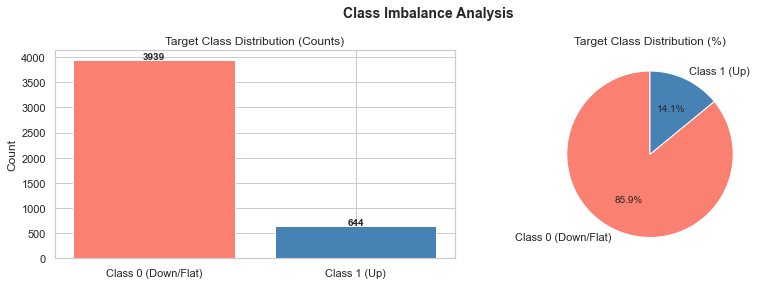

Class balance: 85.9% down/flat, 14.1% up


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
counts = train_df["target"].value_counts()
axes[0].bar(["Class 0 (Down/Flat)", "Class 1 (Up)"], [counts.get(0, 0), counts.get(1, 0)], color=["salmon", "steelblue"])
axes[0].set_title("Target Class Distribution (Counts)")
axes[0].set_ylabel("Count")
for i, v in enumerate([counts.get(0, 0), counts.get(1, 0)]):
    axes[0].text(i, v + 10, str(v), ha="center", fontweight="bold")

# Percentage
pcts = counts / len(train_df) * 100
axes[1].pie([pcts.get(0, 0), pcts.get(1, 0)], labels=["Class 0 (Down/Flat)", "Class 1 (Up)"],
            autopct="%1.1f%%", colors=["salmon", "steelblue"], startangle=90)
axes[1].set_title("Target Class Distribution (%)")

plt.suptitle("Class Imbalance Analysis", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "eda_class_distribution.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Class balance: {pcts.get(0,0):.1f}% down/flat, {pcts.get(1,0):.1f}% up")

In [4]:
# ── Class Imbalance Analysis ──────────────────────────────────────────────────
counts     = train_df["target"].value_counts()
total      = len(train_df)
pct_class1 = counts.get(1, 0) / total * 100
pct_class0 = counts.get(0, 0) / total * 100
threshold  = metadata.get("target_info", {}).get("threshold_pct", "?")

print(f"Target threshold : >= {threshold}% 3-day return")
print(f"Class 0 (no signal): {counts.get(0,0):,}  ({pct_class0:.1f}%)")
print(f"Class 1 (signal)   : {counts.get(1,0):,}  ({pct_class1:.1f}%)")
print(f"Imbalance ratio    : {pct_class0/pct_class1:.1f}:1")
print()

if pct_class1 < 35:
    print("IMBALANCE DETECTED — recommended strategies:")
    print()
    print("  1. class_weight='balanced'  [Logistic Regression, Random Forest]")
    print("     Automatically scales loss inversely proportional to class frequency.")
    print("     No data augmentation needed; preserves temporal ordering.")
    print()
    print("  2. scale_pos_weight = class_0_count / class_1_count  [XGBoost]")
    print(f"     => scale_pos_weight = {pct_class0/pct_class1:.1f}")
    print("     Equivalent to class_weight='balanced' for gradient boosting.")
    print()
    print("  3. Avoid SMOTE / random oversampling:")
    print("     These create synthetic samples by interpolating between existing rows.")
    print("     For time-series data this breaks temporal ordering and leaks information.")
    print()
    print("  ACTION: Update model_config.json to add class_weight and scale_pos_weight.")
    print("          This will be applied automatically in notebook 05.")
else:
    print("Class balance is acceptable — no special handling required.")


Target threshold : >= 1.0% 3-day return
Class 0 (no signal): 3,939  (85.9%)
Class 1 (signal)   : 644  (14.1%)
Imbalance ratio    : 6.1:1

IMBALANCE DETECTED — recommended strategies:

  1. class_weight='balanced'  [Logistic Regression, Random Forest]
     Automatically scales loss inversely proportional to class frequency.
     No data augmentation needed; preserves temporal ordering.

  2. scale_pos_weight = class_0_count / class_1_count  [XGBoost]
     => scale_pos_weight = 6.1
     Equivalent to class_weight='balanced' for gradient boosting.

  3. Avoid SMOTE / random oversampling:
     These create synthetic samples by interpolating between existing rows.
     For time-series data this breaks temporal ordering and leaks information.

  ACTION: Update model_config.json to add class_weight and scale_pos_weight.
          This will be applied automatically in notebook 05.


## Feature Distributions

In [5]:

# ── Skewness Analysis — Candidates for log1p Transform ────────────────────────
# Uses RAW (unnormalized) feature values — Z-scoring removes skewness by definition.

NON_FEATURE_COLS = {"target", "forward_return"}
feat_cols_raw = [c for c in feat_raw_train.columns if c not in NON_FEATURE_COLS]
skewness = feat_raw_train[feat_cols_raw].skew().sort_values(key=abs, ascending=False)

SKEW_THRESHOLD = 1.0
log1p_candidates = skewness[skewness.abs() > SKEW_THRESHOLD].index.tolist()

print(f"Feature skewness (raw values) — threshold = |{SKEW_THRESHOLD}|:")
print(f"{'Feature':<22} {'Skewness':>10}  Note")
print("-" * 50)
for feat, skew in skewness.items():
    flag = "  <-- log1p candidate" if abs(skew) > SKEW_THRESHOLD else ""
    print(f"{feat:<22} {skew:>10.3f}{flag}")

print()
print(f"Recommended log1p transforms ({len(log1p_candidates)}): {log1p_candidates}")


Feature skewness (raw values) — threshold = |1.0|:
Feature                  Skewness  Note
--------------------------------------------------
BB_Width                    3.326  <-- log1p candidate
ATR_pct                     3.174  <-- log1p candidate
VIX_Close                   2.419  <-- log1p candidate
Volume                      2.290  <-- log1p candidate
MACD_line                  -1.631  <-- log1p candidate
MACD_signal                -1.538  <-- log1p candidate
BB_High                     0.830
Close                       0.823
EMA_8                       0.822
EMA_21                      0.821
BB_Low                      0.816
ADX                         0.807
ROC_5                      -0.782
Price_Return_5             -0.782
BB_Position                -0.665
Stoch_K                    -0.595
Stoch_D                    -0.553
ROC_3                      -0.439
RSI                        -0.332
IBS                        -0.257
MACD_hist                  -0.194
Price_Return_1    

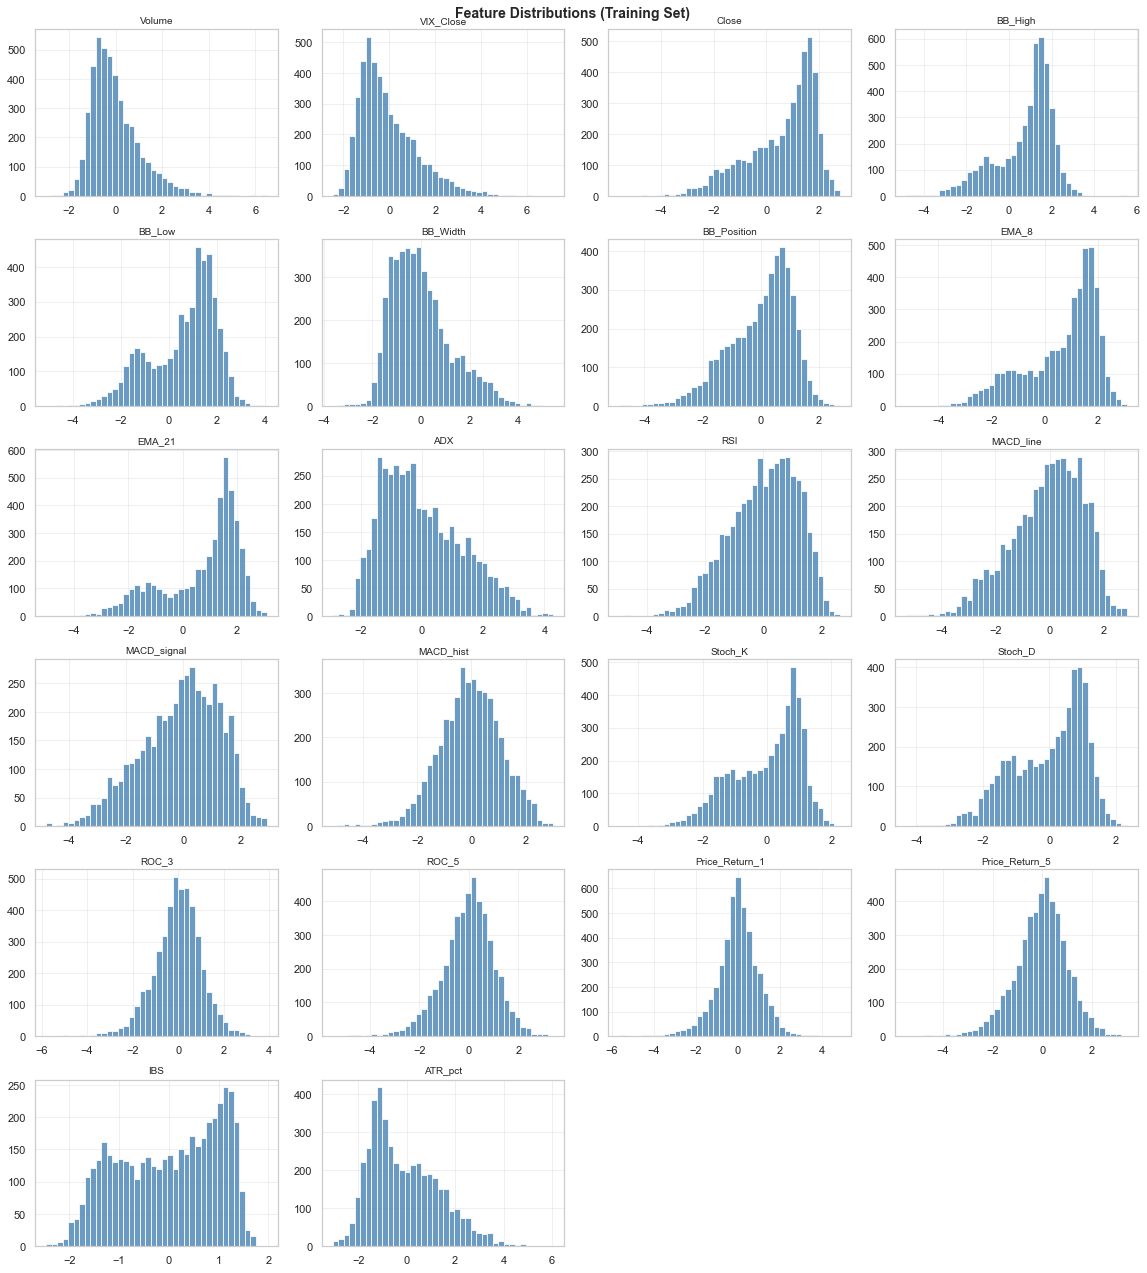

In [6]:
numeric_features = [c for c in feature_cols if c != "Market_Trend"]
n_cols = 4
n_rows = (len(numeric_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    axes[i].hist(train_df[col], bins=40, color="steelblue", edgecolor="white", alpha=0.8)
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel("")
    axes[i].grid(True, alpha=0.3)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Feature Distributions (Training Set)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "eda_feature_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

## Correlation Heatmap

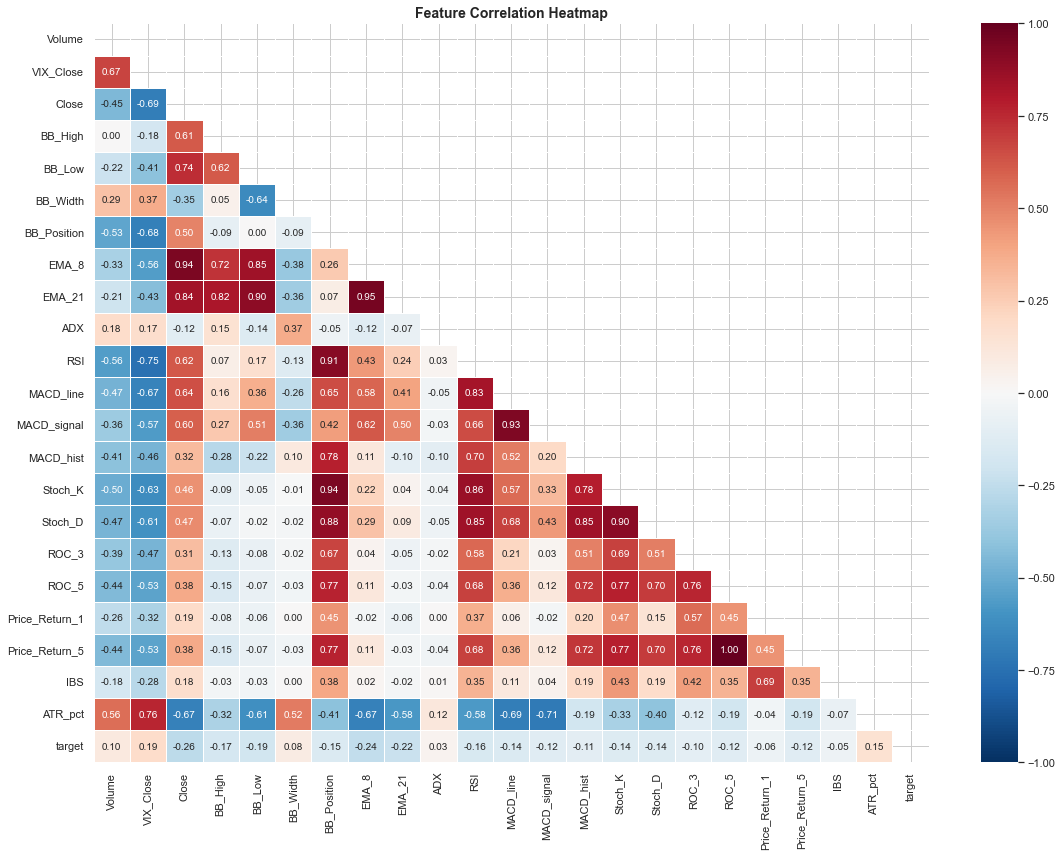

In [7]:
corr_cols = [c for c in feature_cols if c in train_df.columns]
corr_matrix = train_df[corr_cols + ["target"]].corr()

plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="RdBu_r",
            center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "eda_correlation_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

In [8]:
# ── Correlation-Based Feature Analysis ───────────────────────────────────────
import itertools

corr_cols = [c for c in feature_cols if c in train_df.columns]
corr_matrix = train_df[corr_cols].corr().abs()

# Find highly correlated pairs (|r| > 0.85, excluding self)
THRESHOLD = 0.85
high_corr_pairs = []
for c1, c2 in itertools.combinations(corr_cols, 2):
    r = corr_matrix.loc[c1, c2]
    if r >= THRESHOLD:
        high_corr_pairs.append((c1, c2, round(r, 3)))

high_corr_pairs.sort(key=lambda x: -x[2])

if high_corr_pairs:
    print(f"Feature pairs with |correlation| >= {THRESHOLD}:")
    print(f"{'Feature A':<20} {'Feature B':<20} {'|r|':>6}")
    print("-" * 48)
    for c1, c2, r in high_corr_pairs:
        print(f"{c1:<20} {c2:<20} {r:>6.3f}")
    print()
    print("Recommendation: consider dropping one from each highly correlated pair.")
    print("Tree models (RF, XGBoost) are robust to multicollinearity,")
    print("but Logistic Regression can have unstable coefficients.")
    print()
    # Suggest which to drop (keep the one with higher target correlation)
    target_corr_abs = train_df[corr_cols].corrwith(train_df["target"]).abs()
    print("Suggested drops (lower target correlation in each pair):")
    seen = set()
    for c1, c2, r in high_corr_pairs:
        drop = c1 if target_corr_abs[c1] < target_corr_abs[c2] else c2
        if drop not in seen:
            print(f"  Drop '{drop}'  (|target_corr|={target_corr_abs[drop]:.3f})")
            seen.add(drop)
else:
    print(f"No feature pairs exceed the |r| >= {THRESHOLD} threshold.")
    print("Feature set has acceptable multicollinearity.")


Feature pairs with |correlation| >= 0.85:
Feature A            Feature B               |r|
------------------------------------------------
ROC_5                Price_Return_5        1.000
EMA_8                EMA_21                0.954
BB_Position          Stoch_K               0.941
Close                EMA_8                 0.939
MACD_line            MACD_signal           0.930
BB_Position          RSI                   0.912
Stoch_K              Stoch_D               0.899
BB_Low               EMA_21                0.896
BB_Position          Stoch_D               0.882
RSI                  Stoch_K               0.864

Recommendation: consider dropping one from each highly correlated pair.
Tree models (RF, XGBoost) are robust to multicollinearity,
but Logistic Regression can have unstable coefficients.

Suggested drops (lower target correlation in each pair):
  Drop 'Price_Return_5'  (|target_corr|=0.122)
  Drop 'EMA_21'  (|target_corr|=0.225)
  Drop 'Stoch_K'  (|target_corr|=0.138

## Feature-Target Correlation

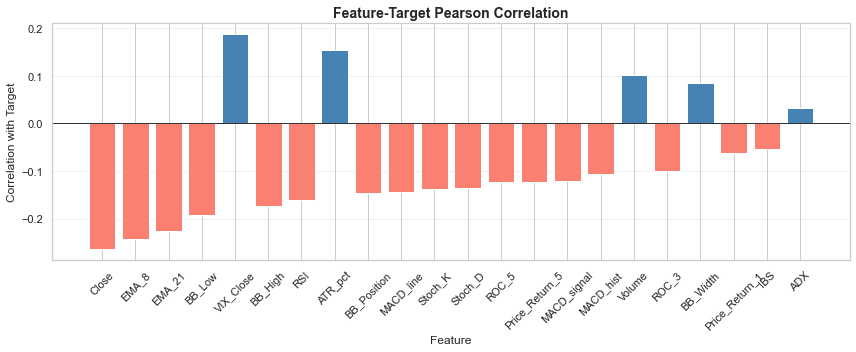

In [9]:
target_corr = train_df[corr_cols].corrwith(train_df["target"]).sort_values(key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
colors = ["steelblue" if v >= 0 else "salmon" for v in target_corr.values]
ax.bar(target_corr.index, target_corr.values, color=colors, edgecolor="white")
ax.axhline(y=0, color="black", linewidth=0.8)
ax.set_title("Feature-Target Pearson Correlation", fontsize=14, fontweight="bold")
ax.set_xlabel("Feature")
ax.set_ylabel("Correlation with Target")
ax.tick_params(axis="x", rotation=45)
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "eda_feature_target_correlation.png", dpi=150, bbox_inches="tight")
plt.show()

In [10]:
# ── Feature Predictive Strength Analysis ─────────────────────────────────────
corr_cols = [c for c in feature_cols if c in train_df.columns]
target_corr = train_df[corr_cols].corrwith(train_df["target"]).sort_values(key=abs, ascending=False)

TOP_N    = 5
BOTTOM_N = 5
WEAK_THRESHOLD = 0.02

print("Top predictive features (linear correlation with target):")
for feat, val in target_corr.head(TOP_N).items():
    print(f"  {feat:<22} r = {val:+.4f}")

print()
print("Weakest features (candidates for removal):")
weak_features = [f for f, v in target_corr.items() if abs(v) < WEAK_THRESHOLD]
for feat in target_corr.tail(BOTTOM_N).index:
    print(f"  {feat:<22} r = {target_corr[feat]:+.4f}")

print()
print("Note: Linear correlation alone is insufficient — check mutual information scores")
print("(cell below) to catch nonlinear relationships before dropping any feature.")


Top predictive features (linear correlation with target):
  Close                  r = -0.2639
  EMA_8                  r = -0.2432
  EMA_21                 r = -0.2250
  BB_Low                 r = -0.1919
  VIX_Close              r = +0.1874

Weakest features (candidates for removal):
  ROC_3                  r = -0.1003
  BB_Width               r = +0.0838
  Price_Return_1         r = -0.0615
  IBS                    r = -0.0547
  ADX                    r = +0.0318

Note: Linear correlation alone is insufficient — check mutual information scores
(cell below) to catch nonlinear relationships before dropping any feature.


## Time Series Plots

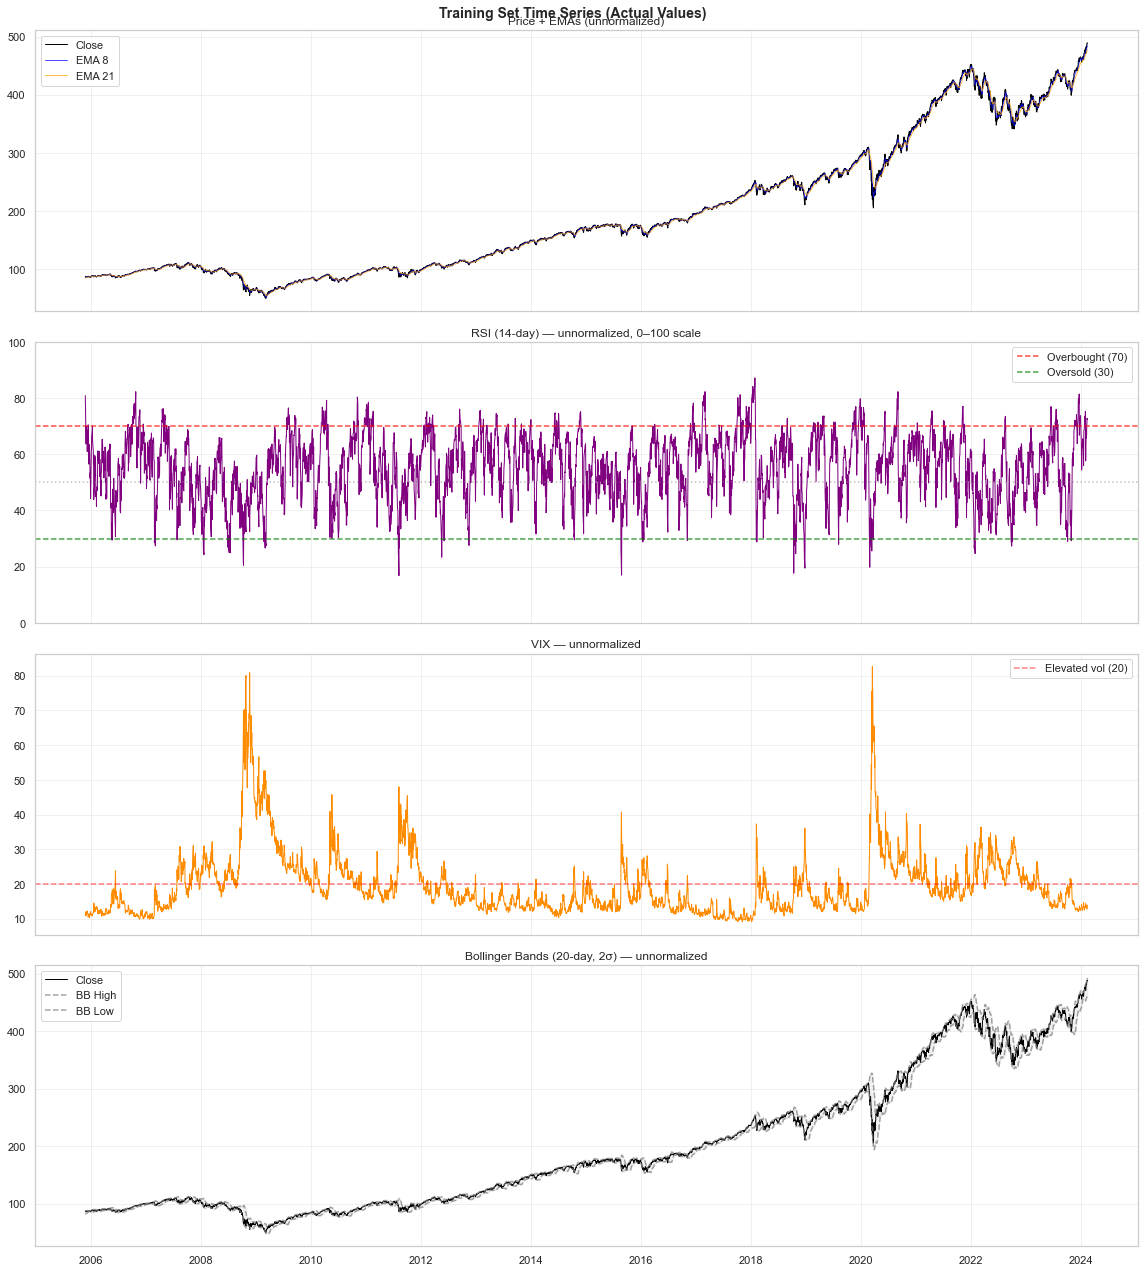

In [11]:
# Time series plots use UNNORMALIZED data so indicators show true scale
fig, axes = plt.subplots(4, 1, figsize=(16, 18), sharex=True)

# Price + EMAs
ax = axes[0]
ax.plot(feat_raw_train.index, feat_raw_train["Close"], label="Close", color="black", linewidth=1)
if "EMA_8" in feat_raw_train.columns:
    ax.plot(feat_raw_train.index, feat_raw_train["EMA_8"],  label="EMA 8",  color="blue",   alpha=0.7, linewidth=1)
if "EMA_21" in feat_raw_train.columns:
    ax.plot(feat_raw_train.index, feat_raw_train["EMA_21"], label="EMA 21", color="orange", alpha=0.7, linewidth=1)
ax.set_title("Price + EMAs (unnormalized)")
ax.legend(); ax.grid(True, alpha=0.3)

# RSI — correct 0–100 scale
ax = axes[1]
ax.plot(feat_raw_train.index, feat_raw_train["RSI"], color="purple", linewidth=1)
ax.axhline(y=70, color="red",   linestyle="--", alpha=0.7, label="Overbought (70)")
ax.axhline(y=30, color="green", linestyle="--", alpha=0.7, label="Oversold (30)")
ax.axhline(y=50, color="gray",  linestyle=":",  alpha=0.5)
ax.set_title("RSI (14-day) — unnormalized, 0–100 scale")
ax.set_ylim(0, 100); ax.legend(); ax.grid(True, alpha=0.3)

# VIX
ax = axes[2]
ax.plot(feat_raw_train.index, feat_raw_train["VIX_Close"], color="darkorange", linewidth=1)
ax.axhline(y=20, color="red", linestyle="--", alpha=0.5, label="Elevated vol (20)")
ax.set_title("VIX — unnormalized")
ax.legend(); ax.grid(True, alpha=0.3)

# Bollinger Bands
ax = axes[3]
ax.plot(feat_raw_train.index, feat_raw_train["Close"],   label="Close",   color="black", linewidth=1)
ax.plot(feat_raw_train.index, feat_raw_train["BB_High"], label="BB High", color="gray",  linestyle="--", alpha=0.7)
ax.plot(feat_raw_train.index, feat_raw_train["BB_Low"],  label="BB Low",  color="gray",  linestyle="--", alpha=0.7)
ax.fill_between(feat_raw_train.index, feat_raw_train["BB_Low"], feat_raw_train["BB_High"], alpha=0.1, color="gray")
ax.set_title("Bollinger Bands (20-day, 2σ) — unnormalized")
ax.legend(); ax.grid(True, alpha=0.3)

plt.suptitle("Training Set Time Series (Actual Values)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "eda_time_series.png", dpi=150, bbox_inches="tight")
plt.show()


In [12]:
# ── Time Series Observations ──────────────────────────────────────────────────
print("Key observations from time series plots:")
print()

# RSI distribution
rsi = feat_raw_train["RSI"]
pct_overbought = (rsi > 70).mean() * 100
pct_oversold   = (rsi < 30).mean() * 100
print(f"RSI — overbought (>70): {pct_overbought:.1f}% of training days")
print(f"RSI — oversold   (<30): {pct_oversold:.1f}% of training days")
print(f"RSI — neutral  (30-70): {100-pct_overbought-pct_oversold:.1f}% of training days")
print()

# VIX regimes
vix = feat_raw_train["VIX_Close"]
print(f"VIX — mean: {vix.mean():.1f}, max: {vix.max():.1f}, >30 (stress): {(vix>30).mean()*100:.1f}% of days")
print()
print("Note: The model trains across multiple volatility regimes (2008 GFC, 2020 COVID,")
print("2022 rate shock). ATR_pct and VIX_Close are included to help the model condition")
print("on the current volatility regime.")


Key observations from time series plots:

RSI — overbought (>70): 9.0% of training days
RSI — oversold   (<30): 1.7% of training days
RSI — neutral  (30-70): 89.3% of training days

VIX — mean: 19.6, max: 82.7, >30 (stress): 9.5% of days

Note: The model trains across multiple volatility regimes (2008 GFC, 2020 COVID,
2022 rate shock). ATR_pct and VIX_Close are included to help the model condition
on the current volatility regime.


## Mutual Information Scores

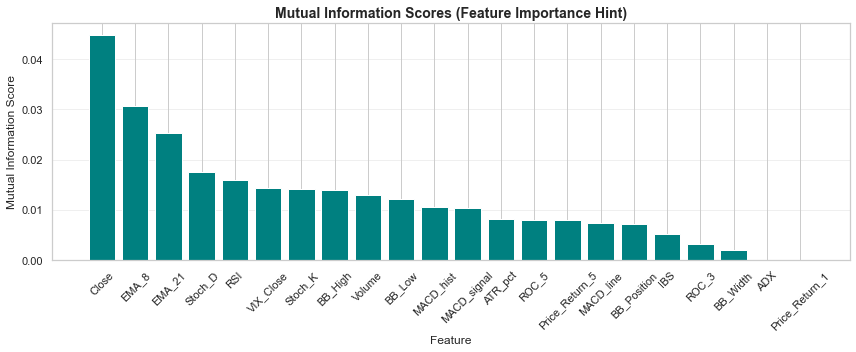


Top 5 features by mutual information:
Close      0.044881
EMA_8      0.030625
EMA_21     0.025275
Stoch_D    0.017440
RSI        0.015828
dtype: float64


In [13]:
from sklearn.feature_selection import mutual_info_classif

X = train_df[corr_cols].fillna(0)
y = train_df["target"]

mi_scores = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=corr_cols).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(mi_series.index, mi_series.values, color="teal", edgecolor="white")
ax.set_title("Mutual Information Scores (Feature Importance Hint)", fontsize=14, fontweight="bold")
ax.set_xlabel("Feature")
ax.set_ylabel("Mutual Information Score")
ax.tick_params(axis="x", rotation=45)
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "eda_mutual_information.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nTop 5 features by mutual information:")
print(mi_series.head(5))

In [14]:
# ── Final Feature Selection Recommendation ────────────────────────────────────
from sklearn.feature_selection import mutual_info_classif

corr_cols = [c for c in feature_cols if c in train_df.columns]
X_mi = train_df[corr_cols].fillna(0)
y_mi = train_df["target"]
mi_scores = mutual_info_classif(X_mi, y_mi, random_state=42)
mi_series  = pd.Series(mi_scores, index=corr_cols).sort_values(ascending=False)

target_corr_abs = train_df[corr_cols].corrwith(train_df["target"]).abs()

print("Feature ranking — combined linear correlation + mutual information:")
print(f"{'Feature':<22} {'|lin_corr|':>12} {'MI_score':>10}  Recommendation")
print("-" * 70)

WEAK_LIN = 0.02
WEAK_MI  = 0.001

keep_features   = []
review_features = []

for feat in mi_series.index:
    lin  = target_corr_abs.get(feat, 0)
    mi   = mi_series[feat]
    if lin < WEAK_LIN and mi < WEAK_MI:
        rec = "CONSIDER DROPPING"
        review_features.append(feat)
    else:
        rec = "keep"
        keep_features.append(feat)
    print(f"{feat:<22} {lin:>12.4f} {mi:>10.4f}  {rec}")

print()
print(f"Features to keep          : {len(keep_features)}")
print(f"Features to review/drop   : {len(review_features)}")
if review_features:
    print(f"  => {review_features}")
print()
print("Final decision will be made in notebook 05 based on model feature importance.")
print("Tree models can handle irrelevant features; LR benefits most from pruning.")


Feature ranking — combined linear correlation + mutual information:
Feature                  |lin_corr|   MI_score  Recommendation
----------------------------------------------------------------------
Close                        0.2639     0.0449  keep
EMA_8                        0.2432     0.0306  keep
EMA_21                       0.2250     0.0253  keep
Stoch_D                      0.1362     0.0174  keep
RSI                          0.1605     0.0158  keep
VIX_Close                    0.1874     0.0144  keep
Stoch_K                      0.1380     0.0142  keep
BB_High                      0.1735     0.0139  keep
Volume                       0.1014     0.0129  keep
BB_Low                       0.1919     0.0121  keep
MACD_hist                    0.1055     0.0105  keep
MACD_signal                  0.1212     0.0104  keep
ATR_pct                      0.1550     0.0081  keep
ROC_5                        0.1225     0.0080  keep
Price_Return_5               0.1225     0.0080  keep
MAC

## Save EDA Recommendations

Outputs `eda_recommendations.json` to `results/{PROJECT_FOLDER}/` for use in `04_feature_engineering.ipynb`.

In [15]:

# ── Save EDA Recommendations to JSON ─────────────────────────────────────────
# All analysis uses RAW (unnormalized) data to avoid artefacts from Z-scoring.

import itertools
from datetime import date
from sklearn.feature_selection import mutual_info_classif

NON_FEATURE_COLS = {"target", "forward_return"}
feat_cols_raw = [c for c in feat_raw_train.columns if c not in NON_FEATURE_COLS]

# ── 1. log1p candidates: features with |skewness| > threshold ─────────────────
SKEW_THRESHOLD = 1.0
skewness_raw   = feat_raw_train[feat_cols_raw].skew()
log1p_recommended = sorted(
    skewness_raw[skewness_raw.abs() > SKEW_THRESHOLD].index.tolist()
)

# ── 2. Redundant features: inter-feature |r| > threshold ──────────────────────
CORR_THRESHOLD    = 0.85
corr_raw          = feat_raw_train[feat_cols_raw].corr().abs()
target_corr_raw   = feat_raw_train[feat_cols_raw].corrwith(feat_raw_train["target"]).abs()

high_corr_pairs = []
redundant_drops = []
seen = set()
for c1, c2 in itertools.combinations(feat_cols_raw, 2):
    r = corr_raw.loc[c1, c2]
    if r >= CORR_THRESHOLD:
        drop = c1 if target_corr_raw.get(c1, 0) < target_corr_raw.get(c2, 0) else c2
        high_corr_pairs.append({
            "feature_a": c1, "feature_b": c2, "correlation": round(float(r), 4)
        })
        if drop not in seen:
            redundant_drops.append(drop)
            seen.add(drop)

# ── 3. Low-signal features: low linear correlation AND low MI ─────────────────
LIN_THRESHOLD = 0.02
MI_THRESHOLD  = 0.001

X_raw = feat_raw_train[feat_cols_raw].fillna(0)
y_raw = feat_raw_train["target"]
mi_scores_raw = mutual_info_classif(X_raw, y_raw, random_state=42)
mi_series_raw = pd.Series(mi_scores_raw, index=feat_cols_raw)
lin_corr_raw  = target_corr_raw

low_signal_drops = sorted([
    f for f in feat_cols_raw
    if lin_corr_raw.get(f, 0) < LIN_THRESHOLD and mi_series_raw[f] < MI_THRESHOLD
])

# ── Build and save recommendations ────────────────────────────────────────────
recommendations = {
    "generated_at":   str(date.today()),
    "project_folder": PROJECT_FOLDER,
    "thresholds": {
        "skewness_for_log1p":        SKEW_THRESHOLD,
        "correlation_for_redundancy": CORR_THRESHOLD,
        "lin_corr_for_low_signal":   LIN_THRESHOLD,
        "mi_for_low_signal":         MI_THRESHOLD,
    },
    "log1p_transforms": {
        "recommended": log1p_recommended,
        "skewness":    {f: round(float(skewness_raw[f]), 3) for f in log1p_recommended},
    },
    "redundant_features": {
        "high_corr_pairs":   high_corr_pairs,
        "recommended_drops": redundant_drops,
    },
    "low_signal_features": {
        "recommended_drops": low_signal_drops,
        "details": {
            f: {
                "lin_corr": round(float(lin_corr_raw.get(f, 0)), 4),
                "mi_score": round(float(mi_series_raw.get(f, 0)), 6),
            }
            for f in low_signal_drops
        },
    },
}

out_path = RESULTS_DIR / "eda_recommendations.json"
with open(out_path, "w") as fp:
    json.dump(recommendations, fp, indent=2)

print(f"Saved: {out_path}")
print()
print(f"log1p transforms recommended  : {log1p_recommended}")
print(f"Redundant features to drop    : {redundant_drops}")
print(f"Low-signal features to drop   : {low_signal_drops}")
print()
print("Load eda_recommendations.json in notebook 04_feature_engineering.ipynb.")


Saved: /Users/sharannaribole/Documents/github/stock-return-classifier/results/spy_run/eda_recommendations.json

log1p transforms recommended  : ['ATR_pct', 'BB_Width', 'MACD_line', 'MACD_signal', 'VIX_Close', 'Volume']
Redundant features to drop    : ['ATR_pct', 'Close', 'BB_Low', 'EMA_8', 'EMA_21', 'BB_Width', 'BB_Position', 'Stoch_K', 'Stoch_D', 'MACD_signal', 'Price_Return_5']
Low-signal features to drop   : []

Load eda_recommendations.json in notebook 04_feature_engineering.ipynb.
